<a href="https://colab.research.google.com/github/WajeehaAslam/Parallel-and-distributing-computing/blob/main/Assign_4_sp23_bai_054.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cupy as cp
import cv2
import numpy as np
from matplotlib import pyplot as plt


# 1. Load any image

image_path = "/content/bunny.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError("Image not found. Check path.")


 2. Convert to grayscale


In [9]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = gray_img.shape

In [10]:
!pip install cupy-cuda12x --quiet
import cupy as cp
print(cp.show_config())


OS                           : Linux-6.6.105+-x86_64-with-glibc2.35
Python Version               : 3.12.12
CuPy Version                 : 13.3.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 2.0.2
SciPy Version                : 1.16.2
Cython Build Version         : 0.29.36
Cython Runtime Version       : 3.0.12
CUDA Root                    : /usr/local/cuda
nvcc PATH                    : /usr/local/cuda/bin/nvcc
CUDA Build Version           : 12060
CUDA Driver Version          : 12040
CUDA Runtime Version         : 12060 (linked to CuPy) / 12050 (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Version                : 11203
cuRAND Version               : 10306
cuSOLVER Version             : (11, 6, 3)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 5)
Thrust Version               : 200600
CUB Build Version            : 200600
Jitify Build Version         : <unknown>
cuDNN Bui

In [11]:
!pip install cupy-cuda12x


3. Store in a CuPy matrix

In [12]:
img_gpu = cp.asarray(gray_img)

4. CUDA Kernel (Reduce size by 50%)

In [13]:
# Kernel explanation:
# - Each (x, y) thread corresponds to one pixel in the output image.
# - We sample from the original image using 2x coordinates (nearest-neighbor interpolation).

cuda_kernel = r'''
extern "C" __global__
void downscale_half(const unsigned char* input, unsigned char* output,
                    int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int new_width = width / 2;
    int new_height = height / 2;

    if (x < new_width && y < new_height) {
        int src_x = x * 2;
        int src_y = y * 2;
        output[y * new_width + x] = input[src_y * width + src_x];
    }
}
'''

# Compile kernel
downscale_half = cp.RawKernel(cuda_kernel, 'downscale_half')



5. Launch kernel using 2D grids/blocks

In [14]:
new_w = w // 2
new_h = h // 2
output_gpu = cp.zeros((new_h, new_w), dtype=cp.uint8)

threads_per_block = (16, 16)
blocks_per_grid_x = (new_w + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (new_h + threads_per_block[1] - 1) // threads_per_block[1]

downscale_half((blocks_per_grid_x, blocks_per_grid_y),
               threads_per_block,
               (img_gpu, output_gpu, np.int32(w), np.int32(h)))

 6. Save and display result

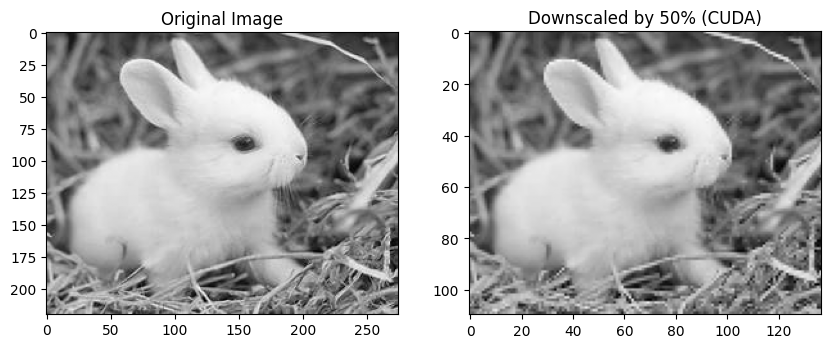

In [15]:
output_cpu = cp.asnumpy(output_gpu)

cv2.imwrite("downscaled_image.jpg", output_cpu)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(gray_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Downscaled by 50% (CUDA)")
plt.imshow(output_cpu, cmap='gray')
plt.show()